# Disease-state discovery on HLCA - reference design comparison

In this notebook we run the disease-state identification workflow on the IPF dataset from Adams et al. comparing ACR, AR and CR reference design. 

See `HLCA_prep_designs.ipynb` for info on data and latent embeddings.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import oor_benchmark

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy

In [2]:
import milopy

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [6]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [7]:
import matplotlib

def plot_milo_diagnostics(nhood_adata, alpha = 0.1, figsize=[12, 12]):
    with matplotlib.rc_context({"figure.figsize": figsize}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(nhood_adata.obs["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(nhood_adata.obs["PValue"], nhood_adata.obs["SpatialFDR"], s=3)
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            nhood_adata.obs["logFC"], -np.log10(nhood_adata.obs["SpatialFDR"]), s=3
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = nhood_adata.obs
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()

In [8]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [9]:
## Define color palette for datasets
pal = sns.color_palette('Paired').as_hex()
dataset_palette = {'Atlas':pal[0], 'Control':pal[1], 'Disease':pal[4]}

In [10]:
import os
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/HLCA_IPF_analysis/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [11]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

## Run milo DA analysis

## Parse results

In [12]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/HLCA/'

In [13]:
acr_adata = milopy.utils.read_milo_adata(data_dir + "Kaminski_2020_oor_design.ACR.h5ad")

In [14]:
ar_adata = milopy.utils.read_milo_adata(data_dir + "Kaminski_2020_oor_design.AR.h5ad", backed=True)

In [15]:
# Here it's CR design with de novo integration (see below for scArches results)
cr_adata = milopy.utils.read_milo_adata(data_dir + "Kaminski_2020_oor_design.CR.h5ad", backed=True)

Add broad annotation groups

In [16]:
all_cts = ar_adata.obs['Celltype_HLCA'].unique().tolist()
all_cts.sort()

ct_groups = {}
ct_groups['macrophages'] = [x for x in all_cts if 'macro' in x or 'Mφ' in x]
ct_groups['fibroblasts'] = [x for x in all_cts if 'fibroblast' in x]
ct_groups['basal'] = [x for x in all_cts if 'basal' in x or "Basal" in x]
ct_groups['AT'] = [x for x in all_cts if "AT" in x]
ct_groups['EC'] = [x for x in all_cts if x.startswith('EC')]
ct_groups['Lymphatic EC'] = [x for x in all_cts if x.startswith('Lymphatic EC')]
ct_groups['Club'] = [x for x in all_cts if "Club" in x]
ct_groups['Goblet'] = [x for x in all_cts if "Goblet" in x]
ct_groups['SMG'] = [x for x in all_cts if "SMG" in x]
ct_groups['Multiciliated'] = [x for x in all_cts if "Multiciliated" in x]
ct_groups['Smooth muscle'] = ['Smooth muscle', 'SM activated stress response']

ct_groups['B/Plasma cells'] = ['B cells',
'Plasma cells']

ct_groups['T cells'] = ['CD4 T cells',
 'CD8 T cells',
 'T cells proliferating']
    
ct_groups['monocytes'] = [
'Classical monocytes', 'Non-classical monocytes']


ct_groups['DCs'] = ['DC1',
 'DC2',
 'Migratory DCs',
 'Plasmacytoid DCs'    
]
 
min_cells = 10

ct_groups_rev = {x:k for k,v in ct_groups.items() for x in v}
for ct in all_cts:
    if sum(acr_adata.obs['Celltype_HLCA'] == ct) < min_cells:
        ct_groups_rev[ct] = np.nan
    else:        
        if ct not in ct_groups_rev.keys():
            ct_groups_rev[ct] = ct


## Plot embeddings

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


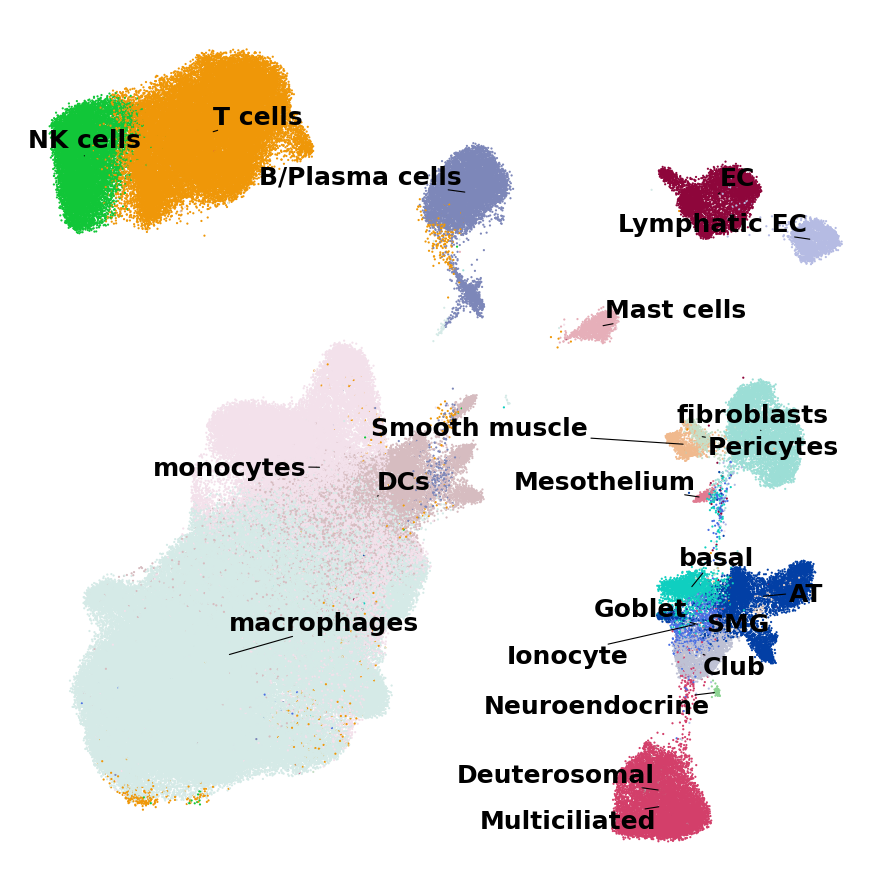

In [34]:
sns.set_context('paper')
with plt.rc_context({'figure.figsize':[9,9]}):
    ax = sc.pl.umap(acr_adata, color=['ct_group'], size=10, 
                legend_fontsize=14, frameon=False,
                title="", show=False, legend_loc=None)
    gen_mpl_labels(
        acr_adata,
        "ct_group",
    #     exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=18, fontweight='bold'),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.savefig(figdir + 'ct_groups_adams.png')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


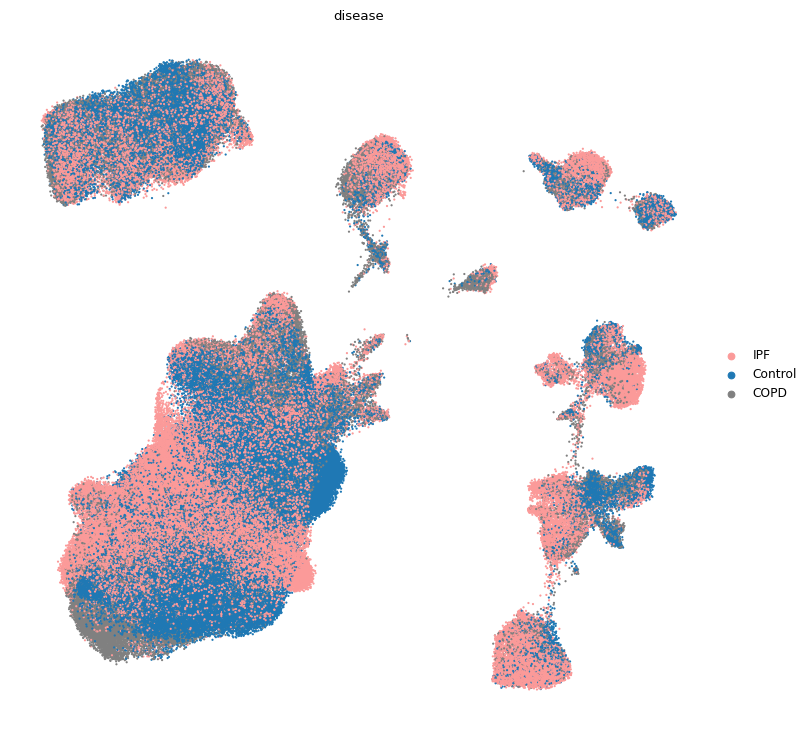

In [104]:
pal = sns.color_palette('Paired').as_hex()
disease_palette = {'Control':pal[1], 'IPF':pal[4], 'COPD':'grey'}

acr_adata.obs['disease'] = acr_adata.obs['disease'].cat.reorder_categories(['IPF', 'Control', 'COPD'])
with plt.rc_context({'figure.figsize':[9,9]}):
    sc.pl.umap(acr_adata, color='disease', palette=disease_palette, frameon=False, show=False, size=10);
    plt.savefig(figdir+'umap_disease_Adams.png')


In [134]:
acr_adata.obs[['disease', 'individual']].drop_duplicates().value_counts('disease')

disease
IPF        32
Control    28
COPD       18
dtype: int64

## Compare scArches integration to scANVI integration on CR design

In [17]:
cr_scarches_adata = milopy.utils.read_milo_adata(data_dir + "Kaminski_2020_oor_design.CR.scArches.h5ad", backed=True)

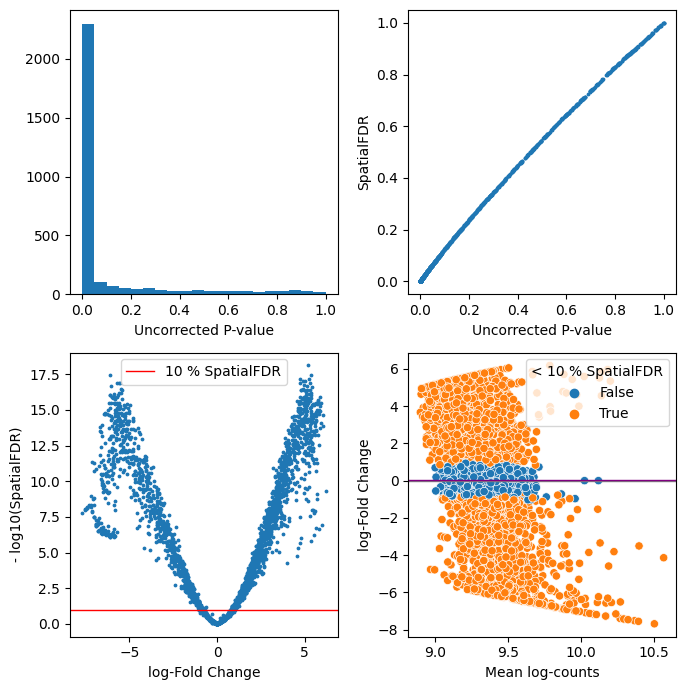

In [18]:
plot_milo_diagnostics(cr_adata.uns['nhood_adata'], figsize=(7,7))

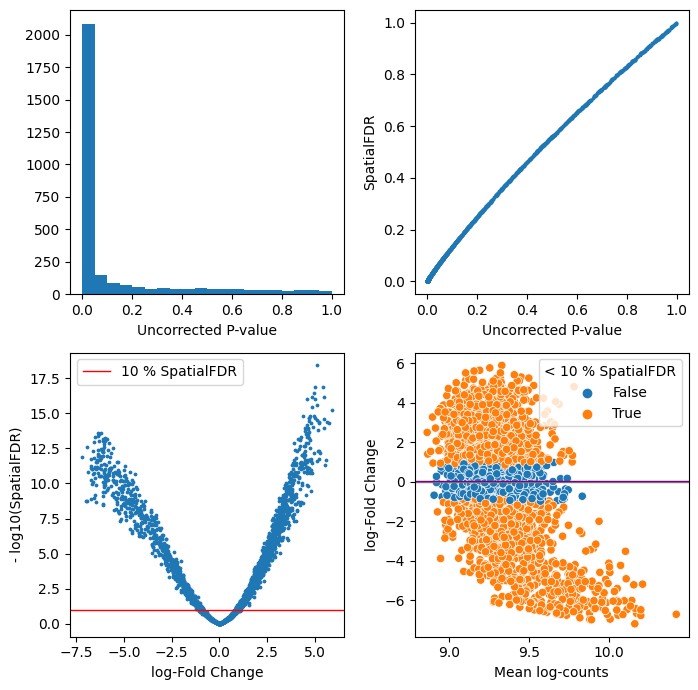

In [19]:
plot_milo_diagnostics(cr_scarches_adata.uns['nhood_adata'], figsize=(7,7))

In [20]:
ar_adata.uns['nhood_adata'] = ar_adata.uns['nhood_adata'].to_memory()
cr_adata.uns['nhood_adata'] = cr_adata.uns['nhood_adata'].to_memory()
cr_scarches_adata.uns['nhood_adata'] = cr_scarches_adata.uns['nhood_adata'].to_memory()

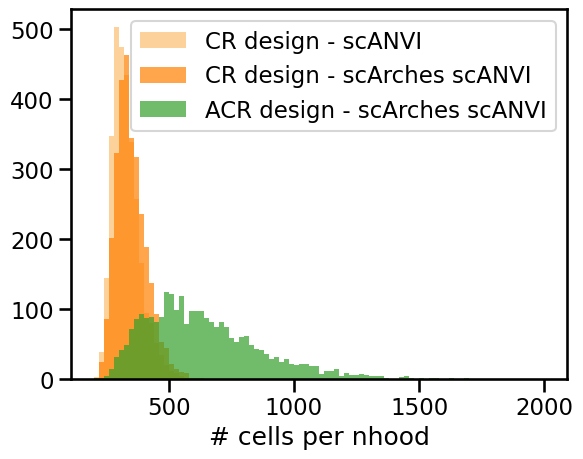

In [21]:
sns.set_context('talk')
binwidth = 20
plt.hist(np.array(cr_adata.obsm['nhoods'].sum(axis=0)).flatten(), 
         bins=np.arange(200, 2000 + binwidth, binwidth), alpha=0.7, label='CR design - scANVI', color=design_palette['CR scVI']);
plt.hist(np.array(cr_scarches_adata.obsm['nhoods'].sum(axis=0)).flatten(), 
         bins=np.arange(200, 2000 + binwidth, binwidth), alpha=0.7, label='CR design - scArches scANVI', color=design_palette['CR scArches']);
plt.hist(np.array(acr_adata.obsm['nhoods'].sum(axis=0)).flatten(), bins=np.arange(200, 2000 + binwidth, binwidth), 
         alpha=0.7, label='ACR design - scArches scANVI', color=design_palette['ACR']);
plt.legend();
plt.xlabel('# cells per nhood');
plt.savefig(figdir + 'n_cells_per_nhood.pdf');
plt.show()

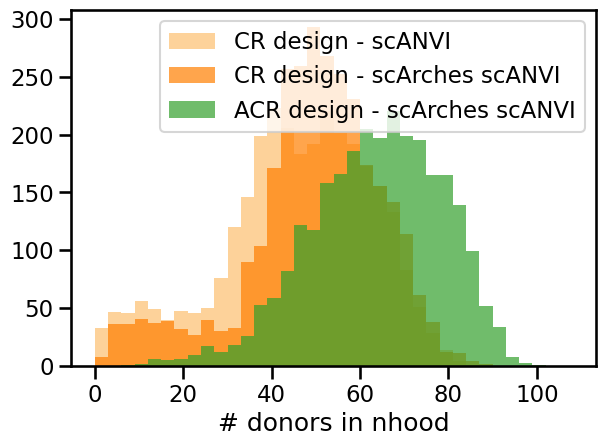

In [22]:
binwidth=3
nhood_adata = cr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='CR design - scANVI',
         color=design_palette['CR scVI']
        );

nhood_adata = cr_scarches_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='CR design - scArches scANVI',
         color=design_palette['CR scArches']
        );


nhood_adata = acr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='ACR design - scArches scANVI',
         color=design_palette['ACR']
        );
plt.legend()
plt.xlabel('# donors in nhood');
plt.tight_layout();
plt.savefig(figdir + 'n_samples_per_donor.pdf');
plt.show()

In [23]:
# def get_nhood_stats(acr_adata):
with plt.rc_context({'figure.figsize':[10,4]}):
    nhood_adata = acr_adata.uns['nhood_adata']
    milo_mat = nhood_adata.X.copy()
    milo_mat[milo_mat.nonzero()] = 1
    n_samples = np.array(milo_mat.sum(1)).flatten()
    n_cells = np.array(acr_adata.obsm['nhoods'].sum(0)).flatten()

    plt.subplot(1,3,1);
    plt.hist2d(n_cells, n_samples, bins=50, norm=matplotlib.colors.LogNorm());
    plt.xlabel("# cells"); plt.ylabel('# samples');
    plt.title("ACR design - scANVI");

    # def get_nhood_stats(acr_adata):
    nhood_adata = cr_adata.uns['nhood_adata']
    milo_mat = nhood_adata.X.copy()
    milo_mat[milo_mat.nonzero()] = 1
    n_samples = np.array(milo_mat.sum(1)).flatten()
    n_cells = np.array(cr_adata.obsm['nhoods'].sum(0)).flatten()

    plt.subplot(1,3,2);
    plt.hist2d(n_cells, n_samples, bins=50, norm=matplotlib.colors.LogNorm());
    plt.xlabel("# cells"); plt.ylabel('# samples');
    plt.title("CR design - scANVI");

    # def get_nhood_stats(acr_adata):
    nhood_adata = cr_scarches_adata.uns['nhood_adata']
    milo_mat = nhood_adata.X.copy()
    milo_mat[milo_mat.nonzero()] = 1
    n_samples = np.array(milo_mat.sum(1)).flatten()
    n_cells = np.array(cr_scarches_adata.obsm['nhoods'].sum(0)).flatten()

    plt.subplot(1,3,3);
    plt.hist2d(n_cells, n_samples, bins=50, norm=matplotlib.colors.LogNorm());
    plt.xlabel("# cells"); plt.ylabel('# samples');
    plt.title("CR design - scANVI scArches");
    plt.tight_layout();
    plt.savefig(figdir+'n_cells_vs_n_samples_nhoods.pdf', bbox_inches='tight');
    plt.savefig(figdir+'n_cells_vs_n_samples_nhoods.png', bbox_inches='tight')

## Compare on IPF diagnostic signature
Signature downloaded from [here](https://bmcmedgenomics.biomedcentral.com/articles/10.1186/1755-8794-4-70#Abs1)

In [24]:
acr_adata.var = acr_adata.var.set_index("gene_name")

### Extract signature genes and weights

In [25]:
IPF_signature = pd.read_csv('/home/jovyan/mount/gdrive/patho-signatures/data/IPF_signature_Meltzer2011.csv') 
IPF_signature = IPF_signature.dropna()
IPF_signature = IPF_signature.groupby('Gene').first().reset_index()
IPF_signature = IPF_signature.sort_values('T.stat', ascending=True)
IPF_signature = IPF_signature[IPF_signature['Gene'].isin(acr_adata.var_names)]

IPF_signature_up = IPF_signature[IPF_signature['T.stat'] > 0]['Gene'].values
IPF_signature_down = IPF_signature[IPF_signature['T.stat'] < 0]['Gene'].values

In [26]:
df = IPF_signature[IPF_signature['T.stat'] > 0]

In [27]:
'SPP1' in IPF_signature['Gene']

False

In [28]:
IPF_signature_up

array(['ANO1', 'ROBO1', 'STMN1', 'COL15A1', 'ROGDI', 'GPX8', 'IGFBP7',
       'RTP4', 'DYRK2', 'FGF1', 'RGS10', 'SCARA3', 'ZNF562', 'ZNF785',
       'ST13', 'NSUN5', 'PDLIM5', 'MZF1', 'ASPM', 'COL1A1', 'SSPN',
       'DDB2', 'NAPEPLD', 'COL8A2', 'COL3A1', 'ASPN', 'ROBO2', 'CXXC5',
       'KIAA0895L', 'ABCC3', 'HGSNAT', 'LRRC17', 'SUPT7L', 'ENC1',
       'PHPT1', 'CFH', 'SMARCC1', 'TSHZ2', 'TRADD', 'PEX12', 'TCEAL7',
       'CDCA7', 'ITGB8', 'RPS27L', 'ZNF573', 'CDCP1', 'PPP2R5E', 'TM7SF3',
       'ZNF260', 'TYMS', 'TSPAN11', 'PTGFRN', 'CXCL12', 'ZNF423',
       'PLXDC1', 'RNF150', 'ECM2', 'PHLDA3', 'ANTXR1', 'C11orf80',
       'FNDC1', 'MDK', 'TTC3', 'PSD3', 'CRIP1', 'CACNB3', 'ZMAT3'],
      dtype=object)

In [30]:
from sklearn.preprocessing import normalize

# Use only up regulated genes
IPF_signature = IPF_signature[IPF_signature['T.stat'] > 0]
IPF_signature_genes = IPF_signature['Gene'].values
IPF_signature_weights = normalize(IPF_signature['T.stat'].values.reshape(1,-1)).flatten()

In [31]:
df = pd.DataFrame(np.vstack([IPF_signature_weights, IPF_signature_genes]).T, columns=['weight', 'gene'])
df['weight'] = df['weight'].astype('float64')

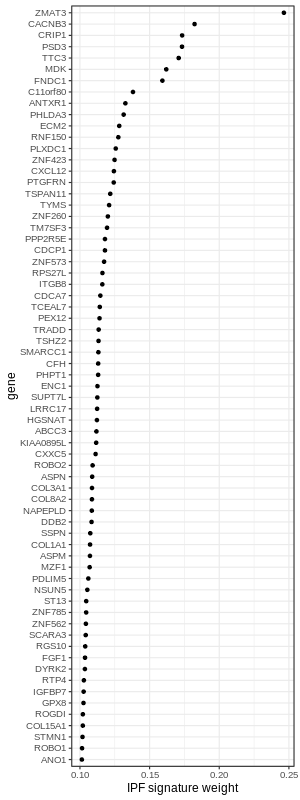

In [32]:
%%R -i df -h 800 -w 300
df %>%
arrange(weight) %>%
mutate(gene=factor(gene, levels=unique(gene))) %>%
ggplot(aes(weight,gene)) +
theme_bw(base_size=12) +
geom_point() +
xlab('IPF signature weight') +
ggsave(paste0(figdir, 'IPF_signature_weight.pdf'), height=8, width=5) +
ggsave(paste0(figdir, 'IPF_signature_weight.png'), height=8, width=5)

### Compute weighted signature score

In [29]:
from scipy.sparse import issparse

def _sparse_nanmean(X, axis):
    """
    np.nanmean equivalent for sparse matrices
    """
    if not issparse(X):
        raise TypeError("X must be a sparse matrix")

    # count the number of nan elements per row/column (dep. on axis)
    Z = X.copy()
    Z.data = np.isnan(Z.data)
    Z.eliminate_zeros()
    n_elements = Z.shape[axis] - Z.sum(axis)

    # set the nans to 0, so that a normal .sum() works
    Y = X.copy()
    Y.data[np.isnan(Y.data)] = 0
    Y.eliminate_zeros()

    # the average
    s = Y.sum(axis, dtype='float64')  # float64 for score_genes function compatibility)
    m = s / n_elements

    return m

def _weighted_score_genes(adata, gene_list, gene_weights, gene_pool=None, use_raw=False, n_bins=25):
    '''Adapting code from scanpy.tl.score_genes'''
    var_names = adata.var_names
    
    if gene_pool is None:
        gene_pool = list(var_names)
    else:
        gene_pool = [x for x in gene_pool if x in var_names]
    if not gene_pool:
        raise ValueError("No valid genes were passed for reference set.")

    # Trying here to match the Seurat approach in scoring cells.
    # Basically we need to compare genes against random genes in a matched
    # interval of expression.

    _adata = adata.raw if use_raw else adata
    _adata_subset = (
        _adata[:, gene_pool] if len(gene_pool) < len(_adata.var_names) else _adata
    )
    if issparse(_adata_subset.X):
        obs_avg = pd.Series(
            np.array(_sparse_nanmean(_adata_subset.X, axis=0)).flatten(),
            index=gene_pool,
        )  # average expression of genes
    else:
        obs_avg = pd.Series(
            np.nanmean(_adata_subset.X, axis=0), index=gene_pool
        )  # average expression of genes

    obs_avg = obs_avg[
        np.isfinite(obs_avg)
    ]  # Sometimes (and I don't know how) missing data may be there, with nansfor

    n_items = int(np.round(len(obs_avg) / (n_bins - 1)))
    obs_cut = obs_avg.rank(method='min') // n_items
    control_genes = list()
    control_weights = list()

    # now pick `ctrl_size` genes from every cut
    for cut in np.unique(obs_cut.loc[gene_list]):
        bin_genes_ixs = obs_cut.loc[gene_list] == cut
        ctrl_size_cut = sum(bin_genes_ixs)
        r_genes = np.array(obs_cut[obs_cut == cut].index)
        np.random.shuffle(r_genes)
        # uses full r_genes if ctrl_size > len(r_genes)
        control_genes.extend(list(set(r_genes[:ctrl_size_cut])))
        control_weights.extend(gene_weights[bin_genes_ixs])

    # To index, we need a list – indexing implies an order.
    control_genes = list(control_genes)
    gene_list = list(gene_list)

    X_list = _adata[:, gene_list].X.toarray()
    X_list = np.average(X_list, axis=1, weights=gene_weights)
    
    X_control = _adata[:, control_genes].X.toarray()
    X_control = np.average(X_control, axis=1, weights=control_weights)
    score = X_list - X_control
    return(score)

In [33]:
sc.pp.normalize_total(acr_adata, target_sum=10000)
sc.pp.log1p(acr_adata)

In [34]:
acr_adata.obs['IPF_signature'] = _weighted_score_genes(
    acr_adata, 
    gene_list=IPF_signature_genes, 
    gene_weights=IPF_signature_weights)

In [ ]:
# sc.pl.umap(acr_adata, color='IPF_signature', size=5, cmap='Spectral');
# sc.pl.umap(acr_adata, color='Celltype_HLCA', size=5, groups=ct_groups['fibroblasts']);

In [36]:
acr_adata.obs['ct_group'] = [ct_groups_rev[ct] for ct in acr_adata.obs['Celltype_HLCA']]

In [39]:
# ## Add signature to all designs (restrict to disease cells, since ctrl data is missing from AR)
acr_adata.obs['IPF_signature_disease'] = np.nan
acr_adata.obs.loc[acr_adata.obs['disease'] == 'IPF','IPF_signature_disease'] = acr_adata.obs.loc[acr_adata.obs['disease'] == 'IPF','IPF_signature']

cr_adata.obs['IPF_signature'] = np.nan
cr_adata.obs.loc[acr_adata.obs_names, 'IPF_signature'] = acr_adata.obs['IPF_signature'].values

cr_adata.obs['IPF_signature_disease'] = np.nan
cr_adata.obs.loc[acr_adata.obs_names, 'IPF_signature_disease'] = acr_adata.obs['IPF_signature_disease'].values
ar_adata.obs['IPF_signature_disease'] = np.nan
ar_adata.obs.loc[acr_adata.obs_names[acr_adata.obs['disease'] == 'IPF'] +"_adams", 'IPF_signature_disease'] = acr_adata.obs.loc[acr_adata.obs['disease'] == 'IPF', 'IPF_signature_disease'].values

### Pick cell lineages of interest

In [51]:
df = acr_adata.obs[['IPF_signature', 'ct_group', 'disease', 'individual']].copy()

## Keep groups with at least 30 control cells
n_all = df.groupby(['ct_group', 'disease']).size().reset_index()
n_all = n_all.pivot(index='ct_group', columns='disease', values=0)
keep_cts = n_all.index[n_all['Control'] > 30].tolist()
df = df[df.ct_group.isin(keep_cts)].copy()
# df['ct_group'] = df['ct_group'].cat.remove_unused_categories()

# order groups by difference in IPF signature btw COPD and IPF
mean_expr = df.groupby(['ct_group', 'disease']).mean('IPF_signature').reset_index()
mean_expr = mean_expr.pivot(index='ct_group', columns='disease', values='IPF_signature')
ct_order = (mean_expr['IPF'] - mean_expr['COPD']).sort_values().index

In [ ]:
df['disease'] = df.disease.cat.reorder_categories(['IPF', 'COPD','Control'])
plt.rcParams['figure.figsize'] = [6,7]
sns.set_context("paper")
fig,ax = plt.subplots()
ax.axvline(x=0, color='grey', linewidth=1, linestyle='--');
sns.boxplot(data=df, y='ct_group', x='IPF_signature', hue='disease', 
            order=ct_order[::-1], fliersize=1, orient='h', ax=ax, palette=disease_palette);
ax.set_ylabel("cell type group", fontsize=16);
ax.set_xlabel("IPF signature", fontsize=16);
ax.tick_params(labelsize=12);
plt.legend(
  bbox_to_anchor=(1.05, 1), # relative position on x and y axis (> 1 indicates outside of axis)
  loc='upper left', # equiv to hjust/vjust in ggplot
  borderaxespad=0, # The pad between the axes and legend border, in font-size units.
  frameon=False,
    title_fontsize=16,
    fontsize=12,
  title='Disease');
fig.tight_layout();
fig.savefig(figdir + 'IPF_signature_select_cts.pdf');
fig.savefig(figdir + 'IPF_signature_select_cts.png')



In [53]:
ipf_sign_ct_groups = ['AT', 'fibroblasts', 'Club', 'basal']

In [54]:
acr_adata.obs['plot_signature'] = np.where(acr_adata.obs.ct_group.isin( ipf_sign_ct_groups ), acr_adata.obs['IPF_signature_disease'], np.nan)
sc.pl.umap(acr_adata, color='plot_signature', size=10, cmap='Spectral', frameon=False, 
          title='Profibrotic stromal signature', show=False)
plt.savefig(figdir + 'IPF_signature.png',  bbox_inches="tight")


### Plot results

In [55]:
## Annotate nhoods by cell type
milopy.utils.annotate_nhoods(acr_adata, anno_col='Celltype_HLCA')
acr_adata.uns['nhood_adata'].obs['nhood_annotation_group'] = [ct_groups_rev[x] for x in acr_adata.uns['nhood_adata'].obs['nhood_annotation']]

milopy.utils.annotate_nhoods(cr_adata, anno_col='Celltype_HLCA')
cr_adata.uns['nhood_adata'].obs['nhood_annotation_group'] = [ct_groups_rev[x] for x in cr_adata.uns['nhood_adata'].obs['nhood_annotation']]

milopy.utils.annotate_nhoods(ar_adata, anno_col='Celltype_HLCA')
ar_adata.uns['nhood_adata'].obs['nhood_annotation_group'] = [ct_groups_rev[x] for x in ar_adata.uns['nhood_adata'].obs['nhood_annotation']]

In [ ]:
ar_adata.uns['nhood_adata'] = ar_adata.uns['nhood_adata'].to_memory()
cr_adata.uns['nhood_adata'] = cr_adata.uns['nhood_adata'].to_memory()

In [57]:
def annotate_nhoods_continuous_nanmean(adata, anno_col):
    nhood_adata = adata.uns['nhood_adata'].copy()
    anno_col_val = np.where(adata.obs[anno_col].isna(), 0, adata.obs[anno_col])
    anno_val = adata.obsm["nhoods"].T.dot(
            scipy.sparse.csr_matrix(anno_col_val).T)
    
    ## Set to nan if less than 5 cells have non nan value 
    # (avoid using the mean of 1/2 cells)
    n_nonnan_cells = np.array(adata.obsm["nhoods"][~adata.obs[anno_col].isna(),:].T.sum(1))
    mean_anno_val = anno_val.toarray()/n_nonnan_cells
    mean_anno_val[n_nonnan_cells < 10] = np.nan

    adata.uns["nhood_adata"].obs[f"nhood_{anno_col}"] = mean_anno_val

In [58]:
## Compute mean IPF signature per nhood
annotate_nhoods_continuous_nanmean(acr_adata, anno_col='IPF_signature_disease')
annotate_nhoods_continuous_nanmean(cr_adata, anno_col='IPF_signature_disease')
annotate_nhoods_continuous_nanmean(ar_adata, anno_col='IPF_signature_disease')

nhood_ACR_df = acr_adata.uns['nhood_adata'].obs.copy()
nhood_ACR_df['design'] = 'ACR'
nhood_AR_df = ar_adata.uns['nhood_adata'].obs.copy()
nhood_AR_df['design'] = 'AR'
nhood_CR_df = cr_adata.uns['nhood_adata'].obs.copy()
nhood_CR_df['design'] = 'CR'

# nhood_CR_df = nhood_CR_df.drop('nhood_IPF_signature_disease', 1)
# nhood_ACR_df = nhood_ACR_df.drop('nhood_IPF_signature_disease', 1)
nhood_ACR_df = nhood_ACR_df[~nhood_ACR_df['nhood_IPF_signature_disease'].isna()]
nhood_CR_df = nhood_CR_df[~nhood_CR_df['nhood_IPF_signature_disease'].isna()]
nhood_AR_df = nhood_AR_df[~nhood_AR_df['nhood_IPF_signature_disease'].isna()]

nhood_df = pd.concat([nhood_ACR_df, nhood_AR_df, nhood_CR_df])
nhood_df['nhood_annotation_frac'] = nhood_df['nhood_annotation_frac'].astype('float64')

/tmp/ipykernel_31249/1800963962.py:11: RuntimeWarning: invalid value encountered in divide
  mean_anno_val = anno_val.toarray()/n_nonnan_cells


In [59]:
nhood_df = nhood_df.convert_dtypes()

In [154]:
%%R -i nhood_df 
head(nhood_df)

             index_cell kth_distance       logFC   logCPM            F
1 001C_AACACGTCACATCCAA     1.571329 -1.91823521 9.904165 15.395668215
2 001C_AGGCCACAGGGATACC     1.825394 -1.22341635 9.293970  6.200624031
3 001C_CAACCTCAGAGTTGGC     1.278895  0.02558571 9.161064  0.003059072
4 001C_CGAACATTCTCTGCTG     1.693444  0.75686576 9.213653  1.865821808
5 001C_CGCGTTTAGTGTCCCG     1.647805 -1.63902837 9.404998  9.004904487
6 001C_CGGACGTGTCCATGAT     1.315055  0.83216205 9.162477  3.464592036
        PValue         FDR   SpatialFDR    nhood_annotation
1 0.0001348108 0.000340647 0.0003661871 Classical monocytes
2 0.0139125873 0.023774233 0.0249432084 Classical monocytes
3 0.9559693983 0.964807873 0.9664793475            NK cells
4 0.1741072509 0.229868741 0.2361984241 Classical monocytes
5 0.0031798782 0.006198491 0.0065664324 Classical monocytes
6 0.0647437558 0.095351165 0.0990286564            NK cells
  nhood_annotation_frac nhood_annotation_group nhood_IPF_signature_disease
1       

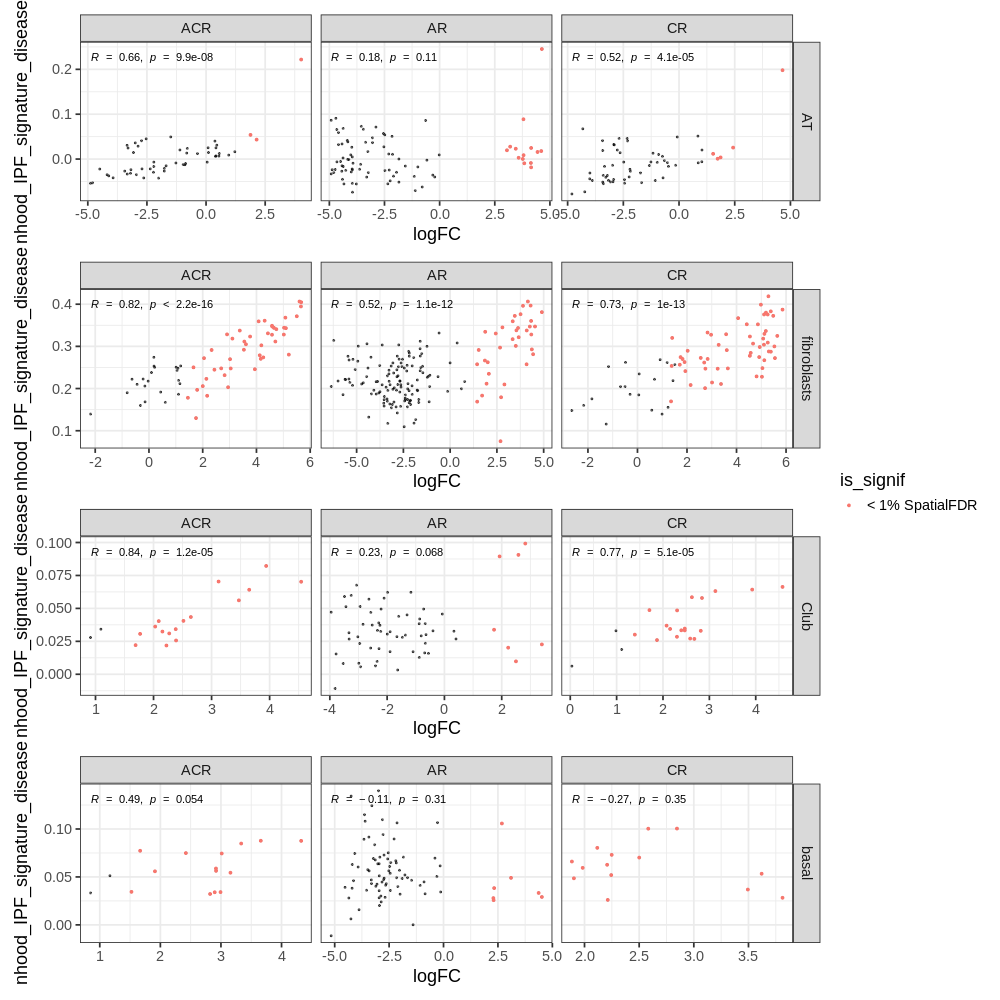

In [155]:
%%R -w 1000 -h 1000 -i ipf_sign_ct_groups
ct_groups = unlist(ipf_sign_ct_groups)

pl_ls <- lapply(ct_groups, function(g) nhood_df %>%
    filter(nhood_annotation_group == g) %>%
    mutate(is_signif = ifelse((SpatialFDR < 0.01 & logFC > 0), '< 1% SpatialFDR', NA)) %>%
    ggplot(aes(logFC, nhood_IPF_signature_disease)) +
    geom_point(size=0.7, color='black', alpha=0.6) +
    geom_point(data=. %>% filter(!is.na(is_signif)),
               size = 1.1,
               aes(color=is_signif)) +
    facet_grid(nhood_annotation_group~design, scale='free') +
    theme_bw(base_size=18) +
    ggpubr::stat_cor())

wrap_plots(pl_ls, ncol=1) +
plot_layout(guides='collect') +
ggsave(paste0(figdir, 'IPF_signature_scatterplot.pdf'), width=10, height=12) 

In [98]:
from oor_benchmark.metrics import auprc

## Mark true positive by quantile
thresh_quantile = nhood_df.groupby('nhood_annotation_group')['nhood_IPF_signature_disease'].quantile(0.50)
nhood_df['OOR_state_group'] = np.nan
for d in ipf_sign_ct_groups:
    nhood_df.loc[nhood_df['nhood_annotation_group'] == d, 'OOR_state_group'] = (nhood_df.loc[nhood_df['nhood_annotation_group'] == d, 'nhood_IPF_signature_disease'] > thresh_quantile[d]).astype('int')
    
# ## Mark true positives by common threshold
# nhood_df['OOR_state_group'] = (nhood_df['nhood_IPF_signature_disease'] > thresh).astype('int')

nhood_df['OOR_score'] = nhood_df['logFC']

auprc_df_all = pd.DataFrame()
for ct in ipf_sign_ct_groups:
    nhood_df_ct = nhood_df[nhood_df['nhood_annotation_group'] == ct]
#     nhood_df_ct = nhood_df
    auprc_acr = auprc.auprc(nhood_df_ct[nhood_df_ct.design == 'ACR'], return_curve=True)
    auprc_acr['design'] = 'ACR'
    auprc_ar = auprc.auprc(nhood_df_ct[nhood_df_ct.design == 'AR'], return_curve=True)
    auprc_ar['design'] = 'AR'
    auprc_cr = auprc.auprc(nhood_df_ct[nhood_df_ct.design == 'CR'], return_curve=True)
    auprc_cr['design'] = 'CR'
    auprc_df = pd.concat([auprc_cr, auprc_acr, auprc_ar])
    auprc_df['nhood_annotation_group'] = ct
    auprc_df_all = pd.concat([auprc_df_all, auprc_df])
#     auprc_df_all = auprc_df

In [99]:
%%R -i auprc_df_all
auprc_df_all %>%
head()


     Recall Precision    AUPRC no_skill_thresh design nhood_annotation_group
1 1.0000000 0.4285714 0.718266       0.4285714     CR                     AT
2 1.0000000 0.4363636 0.718266       0.4285714     CR                     AT
3 0.9583333 0.4259259 0.718266       0.4285714     CR                     AT
4 0.9583333 0.4339623 0.718266       0.4285714     CR                     AT
5 0.9583333 0.4423077 0.718266       0.4285714     CR                     AT
6 0.9583333 0.4509804 0.718266       0.4285714     CR                     AT


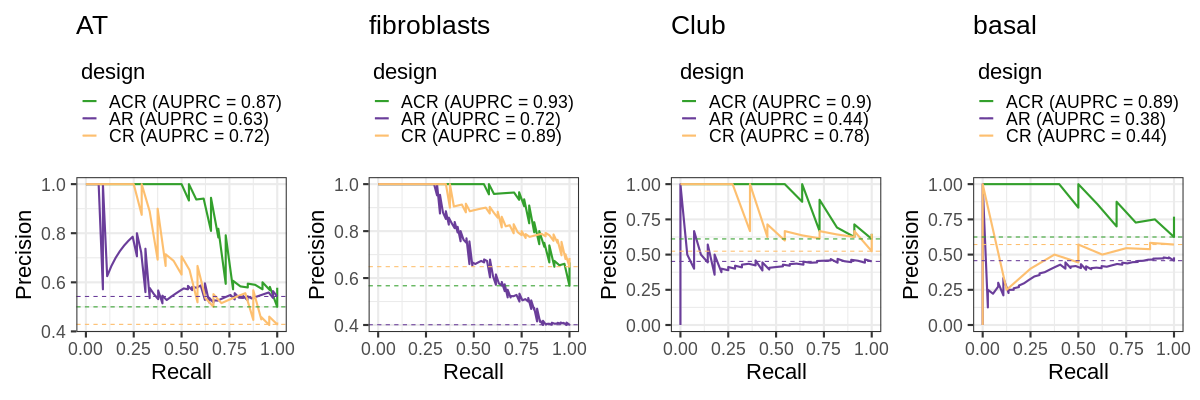

In [113]:
%%R -w 1200 -h 400 

pl_ls <- lapply(unique(auprc_df_all$nhood_annotation_group), function(ct) {
    pl_df <- auprc_df_all %>%
        filter(nhood_annotation_group == ct) %>%  
        mutate(design_labels = str_c(design, ' (AUPRC = ', round(AUPRC, 2), ')')) %>%
        mutate(design = ifelse(design == 'CR', 'CR scVI', design)) 
    
    des_labels = pl_df %>%
        distinct(design, design_labels) 
    
    pl_df %>%        
        ggplot(aes(Recall, Precision, color=design)) +
        geom_line(size=1) +
        geom_hline(data=. %>% group_by(design) %>% summarise(no_skill_thresh = first(no_skill_thresh)), 
                   linetype=2, aes(yintercept=no_skill_thresh, color=design)) +
        scale_color_manual(values=design_palette, labels = setNames(des_labels$design_labels, des_labels$design)) +
        guides(color=guide_legend(ncol=1, title.position='top')) +
        theme_bw(base_size=22) +
        ggtitle(ct) +
        theme(legend.position='top', legend.justification='right') })

wrap_plots(pl_ls) +
    plot_layout(nrow=1) +
    ggsave(paste0(figdir, 'stromal_PRcurve.png'), width=15, height=6) +
    ggsave(paste0(figdir, 'stromal_PRcurve.pdf'), width=15, height=6)

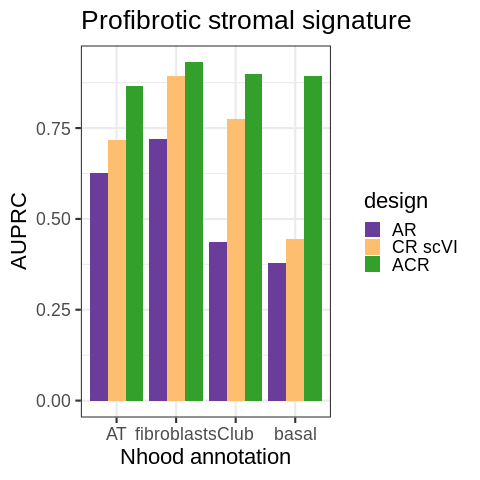

In [122]:
%%R
auprc_df_all %>%
    mutate(design_labels = str_c(design, ' (AUPRC = ', round(AUPRC, 2), ')')) %>%
    mutate(design = ifelse(design == 'CR', 'CR scVI', design)) %>%
    mutate(design=factor(design, levels=c('AR', 'CR scArches', 'CR scVI','ACR'))) %>%
    mutate(nhood_annotation_group = factor(nhood_annotation_group, levels=ct_groups)) %>%
    distinct(AUPRC, no_skill_thresh, design, nhood_annotation_group) %>%
    ggplot(aes(nhood_annotation_group, AUPRC, fill=design)) +
    geom_col(position='dodge') +
    scale_fill_manual(values=design_palette) +
    guides(color=guide_legend(ncol=1, title.position='top')) +
    theme_bw(base_size=22) +
    xlab("Nhood annotation") +
    ggtitle("Profibrotic stromal signature") +
    ggsave(paste0(figdir, 'AUPRC_ipf_signature.pdf'), width=10, height=4) +
    ggsave(paste0(figdir, 'AUPRC_ipf_signature.png'), width=10, height=4)

Check expression of signature genes in different cell types

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


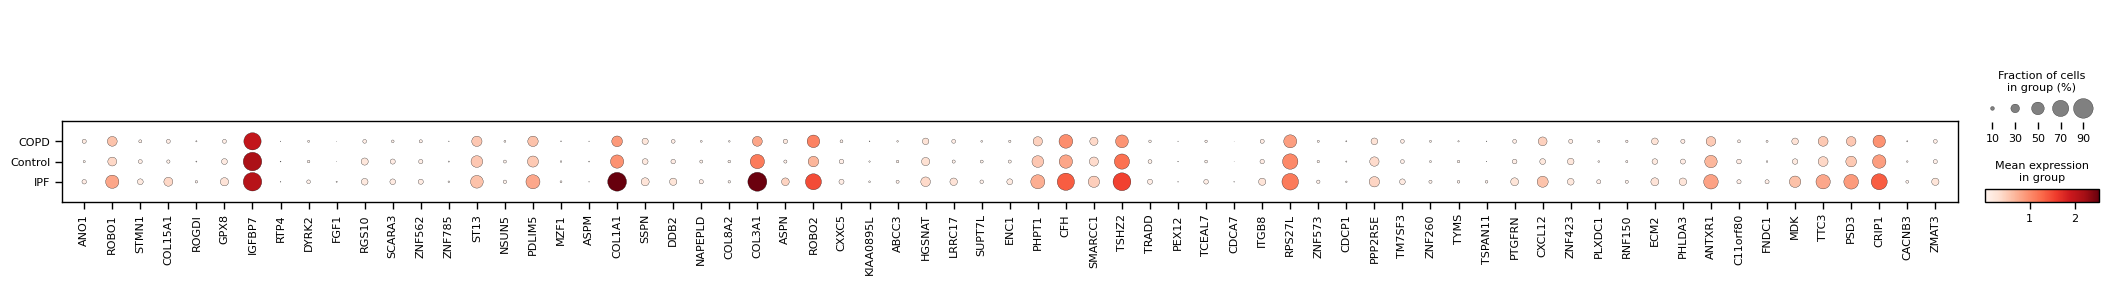

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


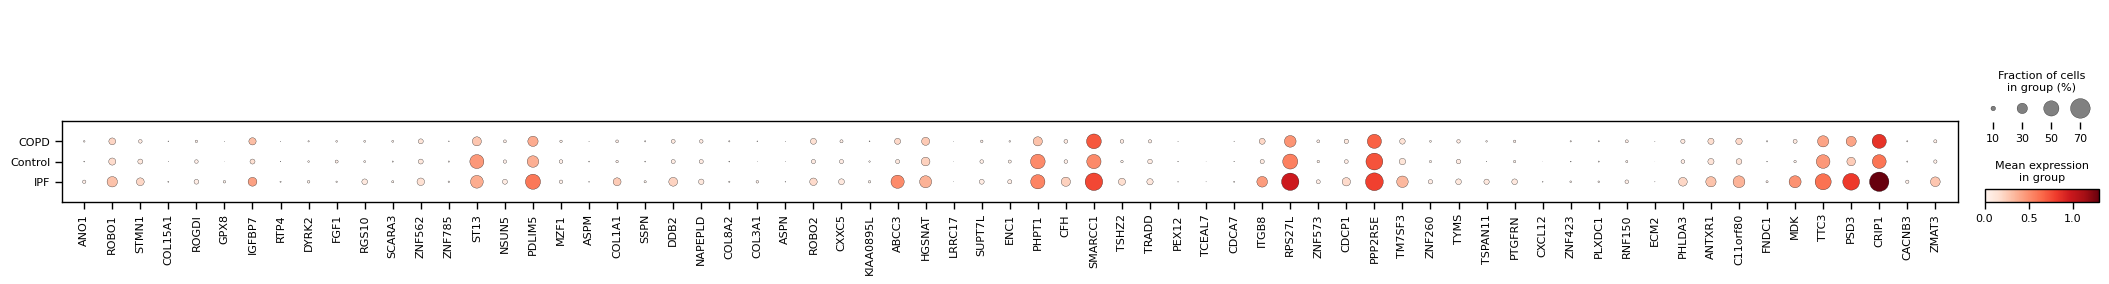

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


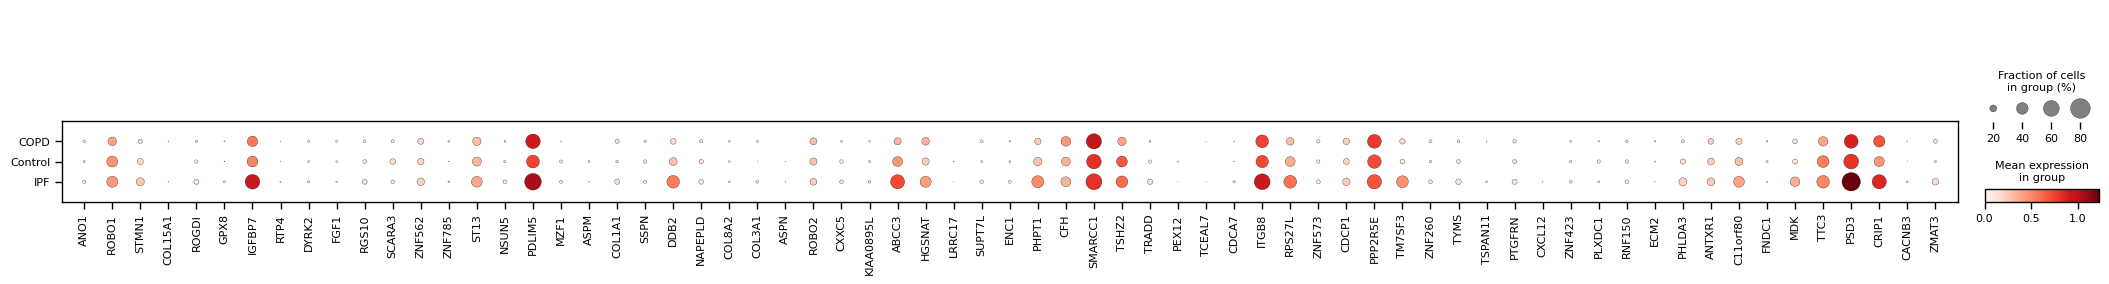

In [831]:
sc.pl.dotplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['fibroblasts'])], IPF_signature_up, groupby='disease')
sc.pl.dotplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['AT'])], IPF_signature_up, groupby='disease')
sc.pl.dotplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])], IPF_signature_up, groupby='disease')

### Visualize basal cell nhoods

In [807]:
# import numpy as np
# from mudata import MuData


def _get_cells_in_nhoods(adata, nhood_ids):
    """Get cells in neighbourhoods of interest, store the number of neighbourhoods for each cell in adata.obs['in_nhoods']"""
    in_nhoods = np.array(adata.obsm["nhoods"][:, nhood_ids.astype("int")].sum(1))
#     adata.obs["in_nhoods"] = (in_nhoods > 0).astype('int')
    adata.obs["in_nhoods"] = in_nhoods 

In [808]:
## Calculate average gene expression per nhood
milopy.utils.add_nhood_expression(acr_adata)

from scipy.sparse import csr_matrix
# Get gene expression matrix
if all(acr_adata.obs_names == cr_adata.obs_names):
    X = acr_adata.X
    expr_id = "expr"

    # Aggregate over nhoods -- taking the mean
    nhoods_X = X.T.dot(cr_adata.obsm["nhoods"])
    nhoods_X = csr_matrix(nhoods_X / cr_adata.obsm["nhoods"].toarray().sum(0))
    cr_adata.uns["nhood_adata"].obsm[expr_id] = nhoods_X.T

In [809]:
basal_nhoods_acr = acr_adata.uns['nhood_adata'][acr_adata.uns['nhood_adata'].obs['nhood_annotation_group'] == 'basal']
basal_nhoods_cr = cr_adata.uns['nhood_adata'][cr_adata.uns['nhood_adata'].obs['nhood_annotation_group'] == 'basal']

In [812]:
## from https://www.nature.com/articles/s41467-022-33193-0/figures/1
IPF_basal_signature = [
    'KRT17', 'KLF4', 'AREG', "CTGF", 'ADAM9', "ITGB8", 'ITGB6', 
    'HBEGF', 'CD24', 'KRT6A', 'ADAM17', "MMP7"]

In [839]:
def get_long_nhood_gex(basal_nhoods_cr, gene_list):
    nhood_meta = basal_nhoods_cr.obs[['logFC', "SpatialFDR", 'nhood_annotation_frac', 'nhood_IPF_signature_disease']].reset_index()
    nhood_meta.columns = ['nhood','logFC', "SpatialFDR", 'nhood_annotation_frac', 'nhood_IPF_signature_disease']
    nhood_meta['n_cells_Control'] = basal_nhoods_cr[:,basal_nhoods_cr.var['disease'] == 'Control'].X.toarray().sum(1)
    nhood_meta['n_cells_IPF'] = basal_nhoods_cr[:,basal_nhoods_cr.var['disease'] == 'IPF'].X.toarray().sum(1)
    cr_nhood_expr = pd.DataFrame(basal_nhoods_cr.obsm['expr'].toarray().T, 
                                 columns= basal_nhoods_cr.obs_names,
                                 index=acr_adata.var_names)
    long_nhood_gex = cr_nhood_expr.loc[gene_list].reset_index().melt('gene_name', var_name='nhood', value_name='gene_expression')
    long_nhood_gex = pd.merge(long_nhood_gex, nhood_meta)
    return(long_nhood_gex)

In [853]:
long_nhood_gex = get_long_nhood_gex(basal_nhoods_acr, IPF_basal_signature)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


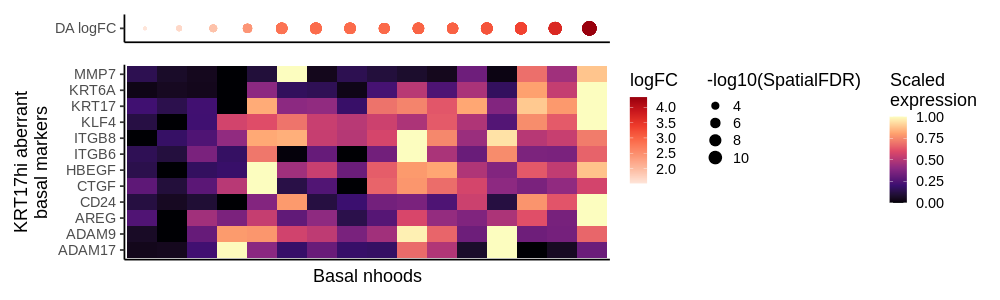

In [854]:
%%R -i long_nhood_gex -w 1000 -h 300

minmax_scale <- function(x){
    (x - min(x))/(max(x) - min(x))
}

pl_df <- long_nhood_gex %>%
    arrange(logFC) %>%
    mutate(nhood = factor(nhood, levels=unique(nhood))) %>%
    group_by(gene_name) %>%
    mutate(scaled_gene_expression = minmax_scale(gene_expression))

p1 <- pl_df %>%
    ggplot(aes(nhood, gene_name, fill=scaled_gene_expression)) +
    geom_tile() +
    xlab('Basal nhoods') +
    theme_classic(base_size=18) +
    scale_fill_viridis_c(option='magma', name='Scaled\nexpression') +
    ylab("KRT17hi aberrant\nbasal markers") +
    theme(axis.ticks.x=element_blank(), axis.text.x=element_blank())

p2 <- pl_df %>%
    ggplot(aes(nhood, 'DA logFC', color=logFC)) +
    geom_point(data=. %>% filter(SpatialFDR < 0.01), aes(size=-log10(SpatialFDR))) +
    ylab('') +
    theme_classic(base_size=18) +
    remove_x_axis() +
    scale_color_distiller(palette='Reds', direction=1)

    
((p2 / p1) + plot_layout(heights=c(1, 7), guides='collect') &
theme( legend.box="horizontal") )+
ggsave(paste0(figdir, 'ACR_basal_KRT17hi_sign.png'), width=15, height=6) +
ggsave(paste0(figdir, 'ACR_basal_KRT17hi_sign.pdf'), width=15, height=6)


In [858]:
long_nhood_gex = get_long_nhood_gex(basal_nhoods_cr, IPF_basal_signature)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


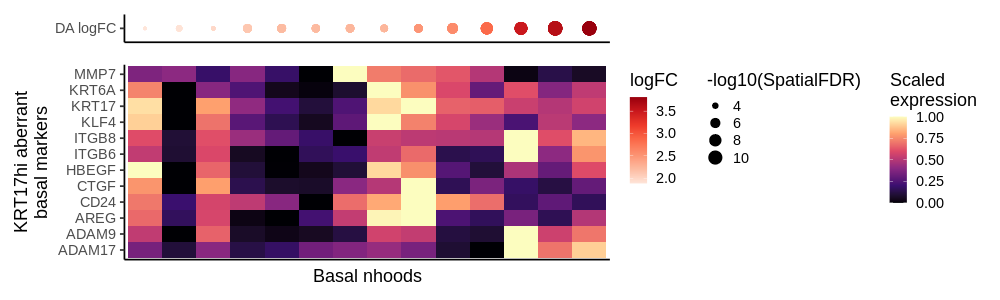

In [859]:
%%R -i long_nhood_gex -w 1000 -h 300

pl_df <- long_nhood_gex %>%
    arrange(logFC) %>%
    mutate(nhood = factor(nhood, levels=unique(nhood))) %>%
    group_by(gene_name) %>%
    mutate(scaled_gene_expression = minmax_scale(gene_expression))

p1 <- pl_df %>%
    ggplot(aes(nhood, gene_name, fill=scaled_gene_expression)) +
    geom_tile() +
    xlab('Basal nhoods') +
    theme_classic(base_size=18) +
    scale_fill_viridis_c(option='magma', name='Scaled\nexpression') +
    ylab("KRT17hi aberrant\nbasal markers") +
    theme(axis.ticks.x=element_blank(), axis.text.x=element_blank())

p2 <- pl_df %>%
    ggplot(aes(nhood, 'DA logFC', color=logFC)) +
    geom_point(data=. %>% filter(SpatialFDR < 0.01), aes(size=-log10(SpatialFDR))) +
    ylab('') +
    theme_classic(base_size=18) +
    remove_x_axis() +
    scale_color_distiller(palette='Reds', direction=1)

    
((p2 / p1) + plot_layout(heights=c(1, 7), guides='collect') &
theme( legend.box="horizontal")) +
ggsave(paste0(figdir, 'CR_basal_KRT17hi_sign.png'), width=15, height=6) +
ggsave(paste0(figdir, 'CR_basal_KRT17hi_sign.pdf'), width=15, height=6)


## Compare on SPP1hi profibrotic macrophages

In [1]:
## From Adams et al
IPF_mac_signature = ['SPP1', 'LIPA', 'LPL', 'FDX1', 'SPARC', 'MATK', 'GPC4', 'PALLD', 'MMP7', 'MMP9', 'CHIT1', "CSTK", 
                     'CHI3L1', 'CSF1', 'FCMR', 'TIMP3','COL22A1', 'SIGLEC15', "CCL2"]
g = IPF_mac_signature[0]

### Profibrotic mac signature

In [43]:
sc.tl.score_genes(acr_adata, gene_list = IPF_mac_signature, score_name = 'profibrotic_mac_signature')

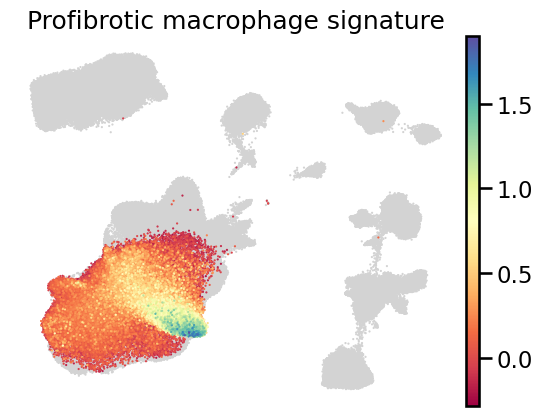

In [131]:
acr_adata.obs['plot_signature'] = np.where(acr_adata.obs.ct_group == 'macrophages', acr_adata.obs['profibrotic_mac_signature'], np.nan)
sc.pl.umap(acr_adata, color='plot_signature', size=10, cmap='Spectral', frameon=False, 
          title='Profibrotic macrophage signature', show=False)
plt.savefig(figdir + 'macs_signature.png',  bbox_inches="tight")
plt.show()

In [44]:
## Add signature to case-control cells  
cr_adata.obs['profibrotic_mac_signature'] = np.nan
cr_adata.obs.loc[acr_adata.obs_names[acr_adata.obs['disease'] == 'IPF'], 'profibrotic_mac_signature'] = acr_adata.obs.loc[acr_adata.obs['disease'] == 'IPF', 'profibrotic_mac_signature'].values
ar_adata.obs['profibrotic_mac_signature'] = np.nan
ar_adata.obs.loc[acr_adata.obs_names[acr_adata.obs['disease'] == 'IPF'] +"_adams", 'profibrotic_mac_signature'] = acr_adata.obs.loc[acr_adata.obs['disease'] == 'IPF', 'profibrotic_mac_signature'].values

acr_adata.obs.loc[acr_adata.obs['disease'] != 'IPF', 'profibrotic_mac_signature'] = np.nan

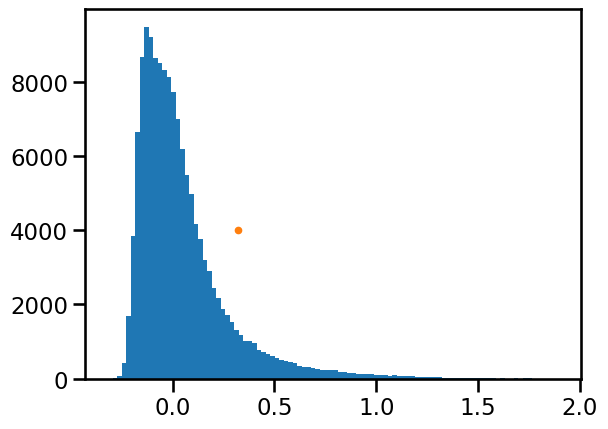

In [45]:
plt.hist(acr_adata.obs['profibrotic_mac_signature'].dropna().values, bins=100);
thresh = acr_adata.obs['profibrotic_mac_signature'].dropna().quantile(0.90)
plt.plot(thresh, 4000, '.');
plt.show()

In [46]:
thresh

0.32093465983678415

In [93]:
## Compute mean IPF signature per nhood
annotate_nhoods_continuous_nanmean(acr_adata, anno_col='profibrotic_mac_signature')
annotate_nhoods_continuous_nanmean(cr_adata, anno_col='profibrotic_mac_signature')
annotate_nhoods_continuous_nanmean(ar_adata, anno_col='profibrotic_mac_signature')

nhood_ACR_df = acr_adata.uns['nhood_adata'].obs.copy()
nhood_ACR_df['design'] = 'ACR'
nhood_AR_df = ar_adata.uns['nhood_adata'].obs.copy()
nhood_AR_df['design'] = 'AR'
nhood_CR_df = cr_adata.uns['nhood_adata'].obs.copy()
nhood_CR_df['design'] = 'CR'

# nhood_CR_df = nhood_CR_df.drop('nhood_IPF_signature_disease', 1)
# nhood_ACR_df = nhood_ACR_df.drop('nhood_IPF_signature_disease', 1)
nhood_ACR_df = nhood_ACR_df[~nhood_ACR_df['nhood_profibrotic_mac_signature'].isna()]
nhood_CR_df = nhood_CR_df[~nhood_CR_df['nhood_profibrotic_mac_signature'].isna()]
nhood_AR_df = nhood_AR_df[~nhood_AR_df['nhood_profibrotic_mac_signature'].isna()]

nhood_df = pd.concat([nhood_ACR_df, nhood_AR_df, nhood_CR_df])
nhood_df['nhood_annotation_frac'] = nhood_df['nhood_annotation_frac'].astype('float64')
nhood_df = nhood_df[nhood_df['nhood_annotation_group'] == 'macrophages']

/tmp/ipykernel_31249/1800963962.py:11: RuntimeWarning: invalid value encountered in divide
  mean_anno_val = anno_val.toarray()/n_nonnan_cells


In [94]:
nhood_df = nhood_df.convert_dtypes()

In [62]:
%%R -i nhood_df
head(nhood_df)

             index_cell kth_distance      logFC   logCPM         F       PValue
1 001C_GATCGATGTCGGCATC     1.977297  1.9142983 8.977884 15.566773 1.242406e-04
2 001C_GGACAAGCAGTCAGCC     1.699642 -2.2491437 9.562309 19.169169 2.292541e-05
3 002C_CGTGAGCGTATGCTTG     2.005885 -0.6194930 9.630553  1.648752 2.012004e-01
4 002C_CTGTTTATCAGGCCCA     2.452399 -0.8035482 8.623768  2.367530 1.261015e-01
5 003C_ACTTGTTCACATCCGG     1.769412 -3.1709369 9.311790 38.852943 4.814723e-09
6 003C_AGCTCTCCAGATGGCA     2.089791 -1.5552429 9.318330 11.055717 1.122775e-03
           FDR   SpatialFDR nhood_profibrotic_mac_signature
1 3.156913e-04 3.392460e-04                    -0.020507640
2 6.953793e-05 7.498275e-05                    -0.010655934
3 2.593651e-01 2.658542e-01                     0.018735986
4 1.725832e-01 1.780869e-01                    -0.026143325
5 3.158505e-08 3.443534e-08                    -0.006335011
6 2.371559e-03 2.526077e-03                     0.090098155
      nhood_annotati

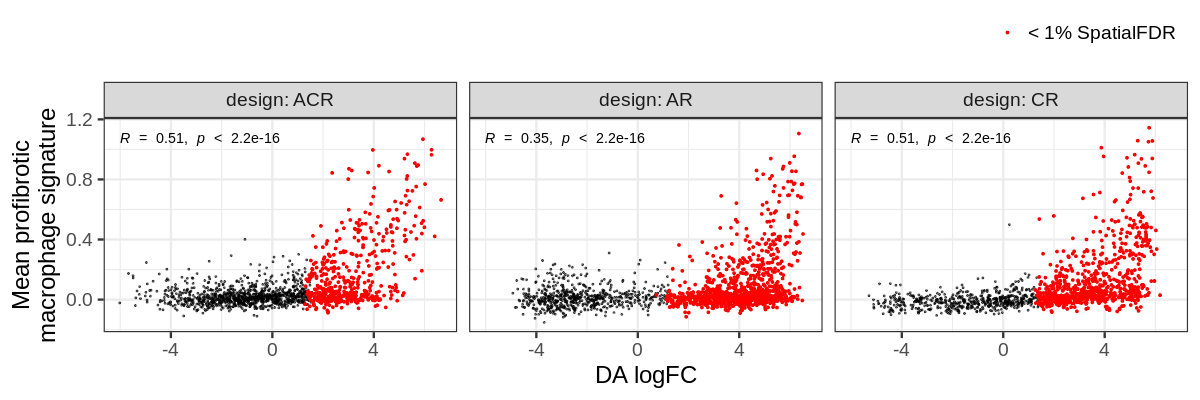

In [63]:
%%R -w 1200 -h 400 -i thresh
ct_groups = c('macrophages')

nhood_df %>%
    filter(nhood_annotation_group == 'macrophages') %>%
    mutate(is_signif = ifelse((SpatialFDR < 0.01 & logFC > 0), '< 1% SpatialFDR', NA)) %>%
    ggplot(aes(logFC, nhood_profibrotic_mac_signature)) +
    geom_point(size=0.7, color='black', alpha=0.6) +
    geom_point(data=. %>% filter(!is.na(is_signif)),
               size = 1.1,
               aes(color=is_signif)) +
    facet_grid(nhood_annotation_group~design, scale='free') +
    theme_bw(base_size=24) +
    facet_wrap(design~., ncol=3, labeller='label_both') +
    scale_color_manual(values='red', name='') +
    ylab('Mean profibrotic\nmacrophage signature') + xlab("DA logFC") +
    ggpubr::stat_cor(size=5) +
    theme(legend.position='top', legend.justification=1) +
    ggsave(paste0(figdir, 'macs_scatter.png'), width=12, height=5) +
    ggsave(paste0(figdir, 'macs_scatter.pdf'), width=12, height=5)

In [95]:
from oor_benchmark.metrics import auprc
    
## Mark true positives by common threshold
nhood_df['OOR_state_group'] = (nhood_df['nhood_profibrotic_mac_signature'] > thresh).astype('int')
nhood_df['OOR_score'] = nhood_df['logFC']

auprc_acr = auprc.auprc(nhood_df[nhood_df.design == 'ACR'], return_curve=True)
auprc_acr['design'] = 'ACR'
auprc_ar = auprc.auprc(nhood_df[nhood_df.design == 'AR'], return_curve=True)
auprc_ar['design'] = 'AR'
auprc_cr = auprc.auprc(nhood_df[nhood_df.design == 'CR'], return_curve=True)
auprc_cr['design'] = 'CR'
auprc_df = pd.concat([auprc_cr, auprc_acr, auprc_ar])

In [96]:
%%R -i auprc_df
head(auprc_df)

  Recall  Precision     AUPRC no_skill_thresh design
1      1 0.09069586 0.5060039      0.09069586     CR
2      1 0.09076682 0.5060039      0.09069586     CR
3      1 0.09083790 0.5060039      0.09069586     CR
4      1 0.09090909 0.5060039      0.09069586     CR
5      1 0.09098039 0.5060039      0.09069586     CR
6      1 0.09105181 0.5060039      0.09069586     CR


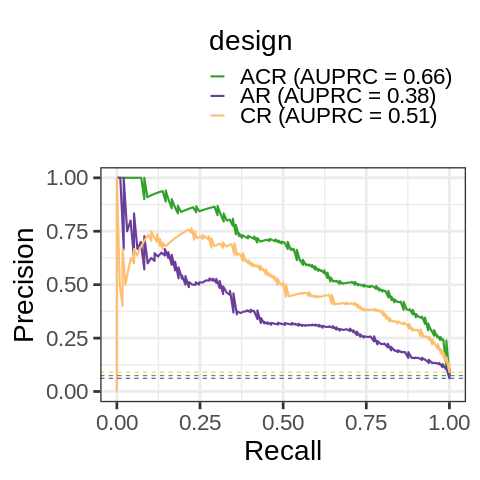

In [97]:
%%R
pl_df <- auprc_df %>%
mutate(design_labels = str_c(design, ' (AUPRC = ', round(AUPRC, 2), ')')) %>%
mutate(design = ifelse(design == 'CR', 'CR scVI', design)) 

des_labels = pl_df %>%
    distinct(design, design_labels) 

pl_df %>%
ggplot(aes(Recall, Precision, color=design)) +
geom_line(size=1) +
geom_hline(data=. %>% group_by(design) %>% summarise(no_skill_thresh = first(no_skill_thresh)), 
           linetype=2, aes(yintercept=no_skill_thresh, color=design)) +
scale_color_manual(values=design_palette, labels = setNames(des_labels$design_labels, des_labels$design)) +
guides(color=guide_legend(ncol=1, title.position='top')) +
theme_bw(base_size=28) +
theme(legend.position='top', legend.justification='right') +
ggsave(paste0(figdir, 'macs_PRcurve.png'), width=6, height=8) +
ggsave(paste0(figdir, 'macs_PRcurve.pdf'), width=6, height=8)


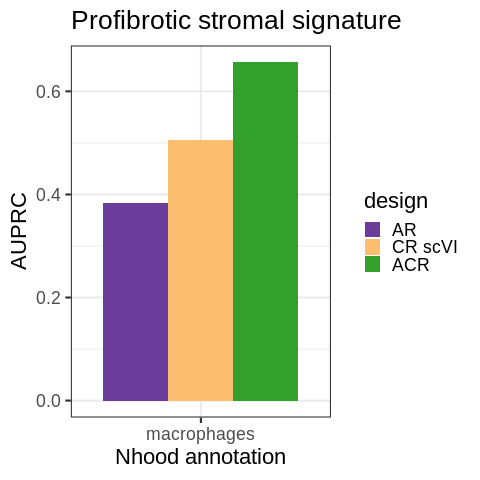

In [151]:
%%R
pl_df <- auprc_df %>%
mutate(design_labels = str_c(design, ' (AUPRC = ', round(AUPRC, 2), ')')) %>%
mutate(design = ifelse(design == 'CR', 'CR scVI', design)) 

pl_df %>%
mutate(design=factor(design, levels=c('AR', 'CR scArches', 'CR scVI','ACR'))) %>%
distinct(AUPRC, no_skill_thresh, design) %>%
ggplot(aes('macrophages', AUPRC, fill=design)) +
geom_col(position='dodge') +
scale_fill_manual(values=design_palette) +
guides(color=guide_legend(ncol=1, title.position='top')) +
theme_bw(base_size=22) +
xlab("Nhood annotation") +
ggtitle("Profibrotic stromal signature") +
ggsave(paste0(figdir, 'AUPRC_macs_signature.pdf'), width=5, height=4) +
ggsave(paste0(figdir, 'AUPRC_macs_signature.png'), width=5, height=4)


### Check the false positives in CR design

In [471]:
def get_FP_nhs(acr_adata, top_perc = 0.05):
    CR_df = acr_adata.uns['nhood_adata'].obs.copy()
    CR_df = CR_df[CR_df['nhood_annotation_group'] == 'macrophages']
    top_CR_df = CR_df[CR_df.logFC > CR_df.quantile(1 - top_perc).logFC]
    FP_nhs = top_CR_df[top_CR_df.nhood_profibrotic_mac_signature < 0.1].index
    return(FP_nhs, top_CR_df.index[~top_CR_df.index.isin(FP_nhs)])

In [472]:
fp_CR, other_CR = get_FP_nhs(cr_adata, top_perc=0.05)
fp_ACR, other_ACR = get_FP_nhs(acr_adata, top_perc=0.05)

/tmp/ipykernel_23959/9227572.py:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  top_CR_df = CR_df[CR_df.logFC > CR_df.quantile(1 - top_perc).logFC]


In [497]:
%%R
p1 <- nhood_df %>%
    filter(design != 'AR') %>%
    group_by(design) %>%
    mutate(thresh = quantile(logFC, 0.95)) %>%
    ungroup() %>%
    mutate(top_perc = logFC >= thresh) %>%
    mutate(mark = ifelse(top_perc & nhood_profibrotic_mac_signature >= 0.1, 'top 10% other',
                  ifelse(top_perc & nhood_profibrotic_mac_signature < 0.1, 'top 10% FP', NA)
                 )) %>%
    mutate(mark = factor(mark, levels=c('top 10% other', 'top 10% FP'))) %>%
    ggplot(aes(logFC, nhood_profibrotic_mac_signature)) +
    geom_point(size=0.5, color='grey') +
    geom_point(data=. %>% filter(!is.na(mark)), aes(color= mark)) +
    geom_vline(aes(xintercept=thresh)) +
    theme_classic(base_size=18) +
    scale_color_brewer(palette='Set1', name='', direction=-1) +
    facet_wrap(design~., ncol=1, labeller='label_both') +
    ylab('Mean profibrotic mac signature') + xlab("DA logFC") +
    theme(legend.position= c(0.25,0.9), strip.background = element_rect(fill='grey90', color=NA))

In [482]:
## Add number of samples per nhood
nhood_adata = cr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
cr_adata.uns['nhood_adata'].obs['n_samples'] = np.array(milo_mat.sum(1)).flatten()

nhood_adata = acr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
acr_adata.uns['nhood_adata'].obs['n_samples'] = np.array(milo_mat.sum(1)).flatten()


In [499]:
df_fp = pd.DataFrame(cr_adata.uns['nhood_adata'][fp_CR,:].obs['n_samples'])
df_fp['type'] = 'top 10%\nFP'
df_oth = pd.DataFrame(cr_adata.uns['nhood_adata'][other_CR,:].obs['n_samples'])
df_oth['type'] = 'top 10%\nother'
pl_df1 = pd.concat([df_fp, df_oth])
pl_df1['design'] = 'CR'

df_fp = pd.DataFrame(acr_adata.uns['nhood_adata'][fp_ACR,:].obs['n_samples'])
df_fp['type'] = 'top 10%\nFP'
df_oth = pd.DataFrame(acr_adata.uns['nhood_adata'][other_ACR,:].obs['n_samples'])
df_oth['type'] = 'top 10%\nother'
pl_df2 = pd.concat([df_fp, df_oth])
pl_df2['design'] = 'ACR'

pl_df = pd.concat([pl_df1, pl_df2])
# plt.subplot(1,2,2);
# sns.boxplot(data=pl_df, x='type', y='n_samples');
# sns.stripplot(data=pl_df, x='type', y='n_samples', color='black');
# plt.ylim(0,70);
# plt.tight_layout();
# plt.show()

In [500]:
%%R -i pl_df
p2 <- pl_df %>%
    mutate(type = factor(type, levels=c('top 10%\nother', 'top 10%\nFP'))) %>%
    ggplot(aes(type, n_samples, color=type)) +
    geom_boxplot() + 
    geom_point(position=position_jitterdodge(jitter.width=0.2), alpha=0.5) +
    scale_color_brewer(palette='Set1', name='', direction=-1) +
    theme_classic(base_size=18) +
    facet_wrap(design~., ncol=1, labeller='label_both') +
    ylab('# samples in nhood') + xlab("") +
    theme(legend.position= 'none', strip.background = element_rect(fill='grey90', color=NA))

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [501]:
ct_df_cr = cr_adata.uns['nhood_adata'][fp_CR,:].to_df().reset_index().melt(id_vars=['index'],value_name = 'n_cells', var_name='individual')
ct_df_cr['design'] = 'CR'

ct_df_acr = acr_adata.uns['nhood_adata'][fp_ACR,:].to_df().reset_index().melt(id_vars=['index'],value_name = 'n_cells', var_name='individual')
ct_df_acr['design'] = 'ACR'

ct_df = pd.concat([ct_df_acr, ct_df_cr])

In [502]:
%%R -i ct_df -w 1500 -h 400
library(RColorBrewer)

p3 <- ct_df %>%
mutate(individ_color = factor(individual, levels=sample(unique(individual)))) %>%
ggplot(aes(index, n_cells, fill=as.numeric(individ_color))) +
geom_col(position='fill', color='black') +
# scale_fill_manual(values = colorRampPalette(brewer.pal(12, "Spectral"))(length(unique(ct_df$individual)))) +
scale_fill_distiller(palette='Spectral') +
guides(fill=guide_colorbar(label=FALSE, breaks=FALSE, title='Donor', title.position='top', title.hjust=0.5)) +
theme_classic(base_size=18) +
xlab('Top 10% FP nhoods') + ylab('Frac. cells') +
facet_grid(.~design, labeller='label_both', scales='free', space='free') +
theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(),
     legend.position='top', legend.justification=1,
      strip.background = element_rect(fill='grey90', color=NA)
     )
# scale_fill_distiller(palette='Spectral')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


Assemble

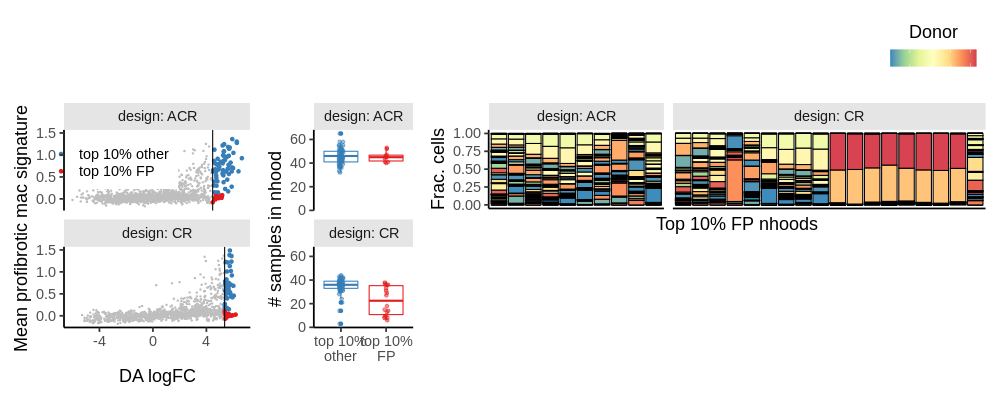

In [503]:
%%R -w 1000 -h 400
library(patchwork)

((p1 + p2) + (p3 / plot_spacer())) +
plot_layout(widths=c(1.5,0.8,4)) +
ggsave(paste0(figdir, 'top10per_FP_macs_figure.pdf'), width=18, height=9) 

### Check SPP1 expression

In [61]:
acr_adata.obs['SPP1_expression'] = acr_adata[:,'SPP1'].X.toarray().flatten()
df = acr_adata.obs[['SPP1_expression', 'CellType_Category', 'disease', 'individual']]

In [83]:
mean_expr = df.groupby(['CellType_Category', 'disease']).mean('SPP1_expression').reset_index()
df.loc[df['SPP1_expression'] > 0, 'SPP1_expression'] = 1
n_expr = df.groupby(['CellType_Category', 'disease']).sum('SPP1_expression').reset_index()
n_expr.columns = ['CellType_Category', 'disease', 'n_expressing']
n_all = df.groupby(['CellType_Category', 'disease']).size().reset_index()
n_all.columns = ['CellType_Category', 'disease', 'tot_cells']
df = pd.merge(pd.merge(mean_expr, n_expr), n_all)

In [85]:
%%R -i df
head(df)

  CellType_Category disease SPP1_expression n_expressing tot_cells
0       Endothelial    COPD      0.01133391           13      1147
1       Endothelial Control      0.02701465           59      2184
2       Endothelial     IPF      0.19187742          789      4112
3        Epithelial    COPD      0.01268231           40      3154
4        Epithelial Control      0.07343458          353      4807
5        Epithelial     IPF      0.25175831         3329     13223


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


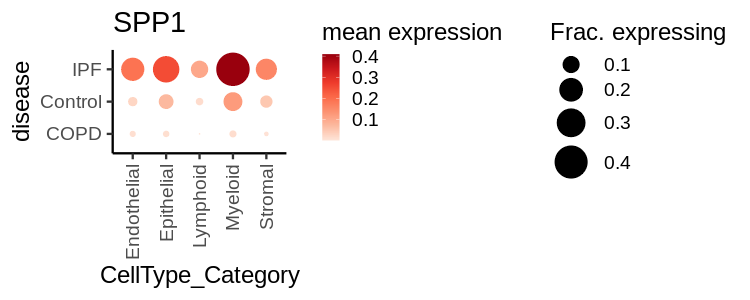

In [114]:
%%R -w 750 -h 300
df %>%
ggplot(aes(CellType_Category, disease)) +
geom_point(aes(size=n_expressing/tot_cells, color=SPP1_expression)) +
scale_color_distiller(palette = "Reds", direction=1, "mean expression") +
scale_size(range=c(0,15), name='Frac. expressing') +
theme_classic(base_size=24) +
ggtitle("SPP1") +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1), legend.box = "horizontal")

### Compare to label transfer uncertainty

From Sikkema et al.

In [116]:
milopy.utils.annotate_nhoods_continuous(acr_adata, 'HLCA_label_transfer_uncertainty')
nhood_df = acr_adata.uns['nhood_adata'].obs.dropna().copy()

In [117]:
## Get dataframe for cell-centric calculation
df1 = acr_adata.obs[['disease', 'profibrotic_mac_signature', 'HLCA_label_transfer_uncertainty']]
df1['OOR_state'] = (df1['profibrotic_mac_signature'] > thresh).astype('int')

/tmp/ipykernel_31249/1547819715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['OOR_state'] = (df1['profibrotic_mac_signature'] > thresh).astype('int')


In [118]:
## Mark true positives by common threshold
nhood_df['OOR_state_group'] = (nhood_df['nhood_profibrotic_mac_signature'] > thresh).astype('int')
nhood_df['OOR_score'] = nhood_df['logFC']

auprc_DA = auprc_acr.copy()
auprc_DA['metric'] = 'DA logFC'
nhood_df['OOR_score'] = nhood_df['nhood_HLCA_label_transfer_uncertainty']
auprc_unc = auprc.auprc(nhood_df, return_curve=True)
auprc_unc['metric'] = 'mean label transfer uncertainty'

df1['OOR_state_group'] = (df1['OOR_state'] == 1).astype('int')
df1['OOR_score'] = df1['HLCA_label_transfer_uncertainty']
auprc_unc_cells = auprc.auprc(df1, return_curve=True)
auprc_unc_cells['metric'] = 'label transfer uncertainty'
auprc_df = pd.concat([auprc_unc, auprc_DA, auprc_unc_cells])

/tmp/ipykernel_31249/3512124170.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['OOR_state_group'] = (df1['OOR_state'] == 1).astype('int')
/tmp/ipykernel_31249/3512124170.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['OOR_score'] = df1['HLCA_label_transfer_uncertainty']


In [119]:
auprc_df = auprc_df.convert_dtypes()

In [120]:
%%R -i auprc_df
head(auprc_df)

  Recall  Precision      AUPRC no_skill_thresh                          metric
1      1 0.04029575 0.04799112      0.04029575 mean label transfer uncertainty
2      1 0.04031065 0.04799112      0.04029575 mean label transfer uncertainty
3      1 0.04032556 0.04799112      0.04029575 mean label transfer uncertainty
4      1 0.04034049 0.04799112      0.04029575 mean label transfer uncertainty
5      1 0.04035542 0.04799112      0.04029575 mean label transfer uncertainty
6      1 0.04037037 0.04799112      0.04029575 mean label transfer uncertainty
  design
1   <NA>
2   <NA>
3   <NA>
4   <NA>
5   <NA>
6   <NA>


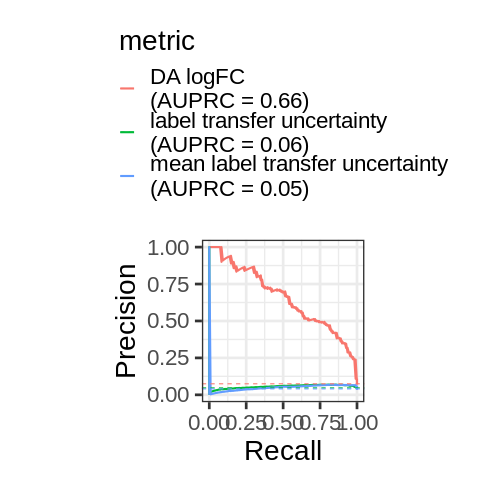

In [127]:
%%R
pl_df <- auprc_df %>%
mutate(metric = str_c(metric, '\n(AUPRC = ', round(AUPRC, 2), ')')) 

pl_df %>%
ggplot(aes(Recall, Precision, color=metric)) +
geom_line(size=1) +
geom_hline(data=. %>% group_by(metric) %>% summarise(no_skill_thresh = first(no_skill_thresh)), 
           linetype=2, aes(yintercept=no_skill_thresh, color=metric)) +
guides(color=guide_legend(ncol=1, title.position='top')) +
theme_bw(base_size=28) +
coord_fixed() +
theme(legend.position='top', legend.justification='right') +
ggsave(paste0(figdir, 'spp1_macs_PR_curve_uncertainty.pdf'), width=7, height=9)


In [122]:
spp1_palette = {1:'salmon', 0:'lightgray'}

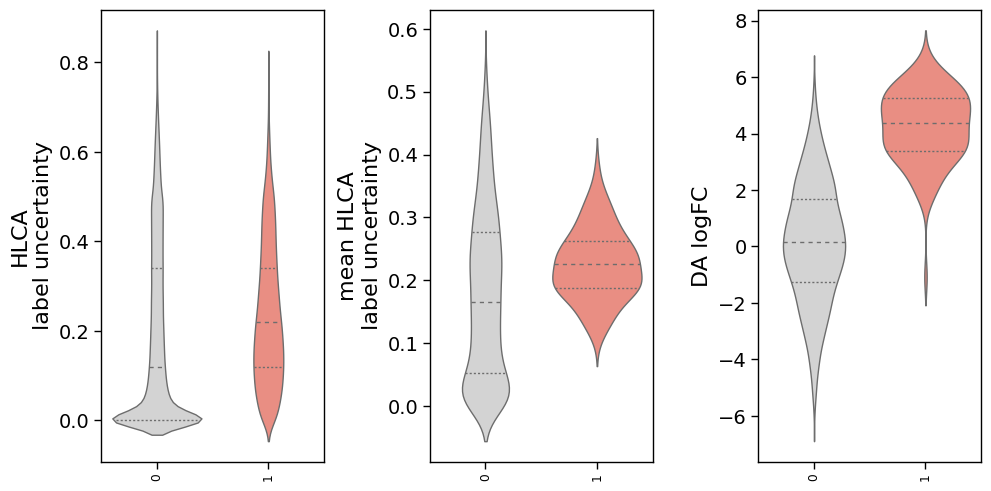

In [124]:
with plt.rc_context({'figure.figsize':[10,5]}):
    plt.subplot(1,3,1);
    sns.violinplot(data=df1, y='HLCA_label_transfer_uncertainty', x='OOR_state_group', 
                             inner="quart", linewidth=1, palette=spp1_palette);
    plt.ylabel('HLCA\nlabel uncertainty', size=16); plt.xlabel('');
    plt.legend([],[], frameon=False);
    plt.yticks(size=14);
    plt.xticks(rotation=90, ha='center');
    plt.subplot(1,3,2);
    sns.violinplot(data=nhood_df, x='OOR_state_group', y='nhood_HLCA_label_transfer_uncertainty',
            inner="quart", linewidth=1, palette=spp1_palette);
    plt.ylabel('mean HLCA\nlabel uncertainty', size=16);
    plt.xlabel('');
    plt.legend([],[], frameon=False);
    plt.xticks(rotation=90, ha='center');
    plt.yticks(size=14);
    plt.subplot(1,3,3);
    sns.violinplot(data=nhood_df, x='OOR_state_group', y='logFC',
            inner="quart", linewidth=1, palette=spp1_palette);
    plt.ylabel('DA logFC', size=16);
    plt.xlabel('');
    plt.legend([],[], frameon=False);
    plt.yticks(size=14);
    plt.xticks(rotation=90, ha='center');
    plt.tight_layout();
    plt.savefig(figdir + '/spp1_macs_uncertainty.pdf');
    plt.show();

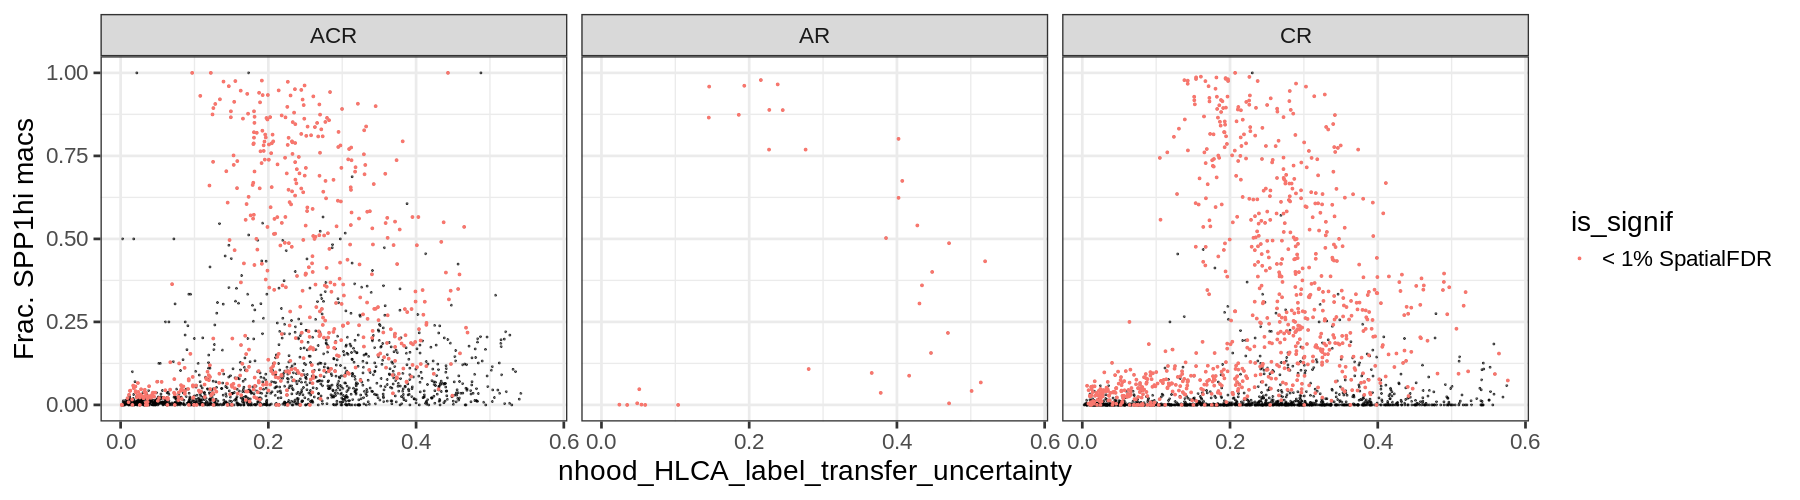

In [214]:
%%R -w 1800 -h 500
nhood_df %>%
mutate(frac_SPP1_macs = ifelse(nhood_annotation == 'SPP1lo', 1- nhood_annotation_frac, nhood_annotation_frac)) %>%
mutate(is_signif = ifelse((SpatialFDR < 0.01 & logFC > 0), '< 1% SpatialFDR', NA)) %>%
ggplot(aes(nhood_HLCA_label_transfer_uncertainty, frac_SPP1_macs)) +
geom_point(size=0.7, color='black', alpha=0.6) +
geom_point(data=. %>% filter(!is.na(is_signif)),
           size = 1.1,
           aes(color=is_signif)) +
theme_bw(base_size=28) +
ylab("Frac. SPP1hi macs") +
facet_grid(.~design) 